# Surface Code Noisy Simulation Benchmarks

Benchmarking paulimer's `FaultySimulation` for stabilizer simulation with Pauli noise.

Based on https://developer.nvidia.com/blog/advanced-large-scale-quantum-simulation-techniques-in-cuquantum-sdk-v25-11/

## Approach
Uses `FaultySimulation` which combines:
- **Noiseless simulation**: Underlying deterministic Clifford simulation
- **Fault profile**: Backward-propagated fault-to-outcome matrix for efficient noisy sampling

In [36]:
import stim
import time
import numpy as np
import matplotlib.pyplot as plt

In [44]:
import paulimer
print('paulimer location:', paulimer.__file__)

paulimer location: /home/adpaetzn/miniconda3/envs/paulimer/lib/python3.12/site-packages/paulimer/__init__.py


In [37]:
# Import paulimer classes
from paulimer import (
    SparsePauli, 
    UnitaryOpcode,
    Circuit,
    Instruction,
    FaultySimulation,
)

In [38]:
# Configuration
NUM_SHOTS = 1_000_000

# Code distances to test (matching the NVIDIA blog range)
# They tested distance 2 to 75, but we'll sample key points
DISTANCES = [2,3,4,5,7,9,11]#,13]#, 15, 17, 19, 21]

# Noise parameter (standard depolarizing noise)
P_NOISE = 0.001

In [39]:
def create_surface_code_circuit(distance: int, p: float = 0.0) -> stim.Circuit:
    """
    Create a rotated surface code memory experiment circuit.
    
    Uses stim's built-in circuit generator with optional noise.
    """
    if p > 0:
        return stim.Circuit.generated(
            "surface_code:rotated_memory_z",
            distance=distance,
            rounds=distance,
            after_clifford_depolarization=p,
            after_reset_flip_probability=p,
            before_measure_flip_probability=p,
        )
    else:
        return stim.Circuit.generated(
            "surface_code:rotated_memory_z",
            distance=distance,
            rounds=distance,
        )

In [40]:
# Mapping from stim gate names to paulimer UnitaryOpcode
STIM_TO_PAULIMER_GATE = {
    "I": UnitaryOpcode.I,
    "H": UnitaryOpcode.Hadamard,
    "X": UnitaryOpcode.X,
    "Y": UnitaryOpcode.Y,
    "Z": UnitaryOpcode.Z,
    "S": UnitaryOpcode.SqrtZ,
    "S_DAG": UnitaryOpcode.SqrtZInv,
    "SQRT_X": UnitaryOpcode.SqrtX,
    "SQRT_X_DAG": UnitaryOpcode.SqrtXInv,
    "SQRT_Y": UnitaryOpcode.SqrtY,
    "SQRT_Y_DAG": UnitaryOpcode.SqrtYInv,
    "CX": UnitaryOpcode.ControlledX,
    "CNOT": UnitaryOpcode.ControlledX,
    "CZ": UnitaryOpcode.ControlledZ,
    "SWAP": UnitaryOpcode.Swap,
}

TWO_QUBIT_GATES = {"CX", "CNOT", "CZ", "SWAP"}

SKIP_INSTRUCTIONS = {
    "TICK", "QUBIT_COORDS", "DETECTOR", "OBSERVABLE_INCLUDE",
    "DEPOLARIZE1", "DEPOLARIZE2", "X_ERROR", "Y_ERROR", "Z_ERROR",
    "PAULI_CHANNEL_1", "PAULI_CHANNEL_2", "E", "ELSE_CORRELATED_ERROR",
}

In [41]:
def stim_circuit_to_paulimer_circuit(stim_circuit: stim.Circuit) -> Circuit:
    """Convert a stim circuit to a paulimer Circuit for FaultySimulation."""
    circuit = Circuit(stim_circuit.num_qubits)
    outcome_id = 0
    
    for instruction in stim_circuit.flattened():
        name = instruction.name
        targets = instruction.targets_copy()
        
        if name in SKIP_INSTRUCTIONS:
            continue
        
        # Resets
        if name in ("R", "RZ"):
            continue
        if name == "RX":
            for t in targets:
                circuit.push(Instruction.unitary(UnitaryOpcode.Hadamard, [t.value]))
            continue
        if name == "RY":
            for t in targets:
                circuit.push(Instruction.unitary(UnitaryOpcode.Hadamard, [t.value]))
                circuit.push(Instruction.unitary(UnitaryOpcode.SqrtZ, [t.value]))
            continue
            
        # Single-qubit measurements
        if name in ("M", "MZ"):
            for t in targets:
                circuit.push(Instruction.measure(SparsePauli.z(t.value), outcome_id))
                outcome_id += 1
            continue
        if name == "MX":
            for t in targets:
                circuit.push(Instruction.measure(SparsePauli.x(t.value), outcome_id))
                outcome_id += 1
            continue
        if name == "MY":
            for t in targets:
                circuit.push(Instruction.measure(SparsePauli.y(t.value), outcome_id))
                outcome_id += 1
            continue
        
        # Two-qubit Pauli measurements
        if name == "MXX":
            for i in range(0, len(targets), 2):
                q0, q1 = targets[i].value, targets[i + 1].value
                circuit.push(Instruction.measure(SparsePauli.x(q0) * SparsePauli.x(q1), outcome_id))
                outcome_id += 1
            continue
        if name == "MYY":
            for i in range(0, len(targets), 2):
                q0, q1 = targets[i].value, targets[i + 1].value
                circuit.push(Instruction.measure(SparsePauli.y(q0) * SparsePauli.y(q1), outcome_id))
                outcome_id += 1
            continue
        if name == "MZZ":
            for i in range(0, len(targets), 2):
                q0, q1 = targets[i].value, targets[i + 1].value
                circuit.push(Instruction.measure(SparsePauli.z(q0) * SparsePauli.z(q1), outcome_id))
                outcome_id += 1
            continue
        
        # Measure-and-reset
        if name in ("MR", "MRZ", "MRX", "MRY"):
            basis_map = {"MR": "Z", "MRZ": "Z", "MRX": "X", "MRY": "Y"}
            basis = basis_map[name]
            for t in targets:
                qubit = t.value
                if basis == "X":
                    circuit.push(Instruction.measure(SparsePauli.x(qubit), outcome_id))
                elif basis == "Y":
                    circuit.push(Instruction.measure(SparsePauli.y(qubit), outcome_id))
                else:
                    circuit.push(Instruction.measure(SparsePauli.z(qubit), outcome_id))
                outcome_id += 1
            continue
        
        # Standard Clifford gates
        if name in STIM_TO_PAULIMER_GATE:
            opcode = STIM_TO_PAULIMER_GATE[name]
            if name in TWO_QUBIT_GATES:
                for i in range(0, len(targets), 2):
                    circuit.push(Instruction.unitary(opcode, [targets[i].value, targets[i + 1].value]))
            else:
                for t in targets:
                    circuit.push(Instruction.unitary(opcode, [t.value]))
            continue
        
        # Gate decompositions
        if name == "CY":
            for i in range(0, len(targets), 2):
                ctrl, targ = targets[i].value, targets[i + 1].value
                circuit.push(Instruction.unitary(UnitaryOpcode.SqrtZInv, [targ]))
                circuit.push(Instruction.unitary(UnitaryOpcode.ControlledX, [ctrl, targ]))
                circuit.push(Instruction.unitary(UnitaryOpcode.SqrtZ, [targ]))
            continue
        if name == "ISWAP":
            for i in range(0, len(targets), 2):
                q0, q1 = targets[i].value, targets[i + 1].value
                circuit.push(Instruction.unitary(UnitaryOpcode.Swap, [q0, q1]))
                circuit.push(Instruction.unitary(UnitaryOpcode.ControlledZ, [q0, q1]))
                circuit.push(Instruction.unitary(UnitaryOpcode.SqrtZ, [q0]))
                circuit.push(Instruction.unitary(UnitaryOpcode.SqrtZ, [q1]))
            continue
        if name == "ISWAP_DAG":
            for i in range(0, len(targets), 2):
                q0, q1 = targets[i].value, targets[i + 1].value
                circuit.push(Instruction.unitary(UnitaryOpcode.SqrtZInv, [q0]))
                circuit.push(Instruction.unitary(UnitaryOpcode.SqrtZInv, [q1]))
                circuit.push(Instruction.unitary(UnitaryOpcode.ControlledZ, [q0, q1]))
                circuit.push(Instruction.unitary(UnitaryOpcode.Swap, [q0, q1]))
            continue
        
        raise ValueError(f"Unhandled stim instruction: {name}")
    
    return circuit

In [17]:
# Quick sanity check
test_stim_circuit = create_surface_code_circuit(distance=3)
print(f"Stim circuit: {test_stim_circuit.num_qubits} qubits, {test_stim_circuit.num_measurements} measurements")

paulimer_circuit = stim_circuit_to_paulimer_circuit(test_stim_circuit)
print(f"\nPaulimer circuit: {paulimer_circuit.num_qubits} qubits, {len(paulimer_circuit)} instructions")
print(f"  Fault locations: {paulimer_circuit.num_faults}")
print(f"  Outcomes: {paulimer_circuit.num_outcomes}")

faulty_sim = FaultySimulation.from_circuit(paulimer_circuit)
print(f"\nFaultySimulation: {faulty_sim.num_faults} faults, {faulty_sim.num_outcomes} outcomes")
samples = faulty_sim.sample(100, 0.001)
print(f"Sample shape: {samples.shape}")
print("✓ Conversion succeeded!")

Stim circuit: 26 qubits, 33 measurements

Paulimer circuit: 26 qubits, 129 instructions
  Fault locations: 402
  Outcomes: 33

FaultySimulation: 402 faults, 33 outcomes
Sample shape: (100, 33)
✓ Conversion succeeded!


In [42]:
def benchmark_stim(circuit: stim.Circuit, num_shots: int) -> float:
    """Benchmark stim including compile_sampler() + sampling."""
    start = time.perf_counter()
    sampler = circuit.compile_sampler()
    samples = sampler.sample(num_shots, bit_packed=True)
    end = time.perf_counter()
    return end - start


def benchmark_paulimer(paulimer_circuit: Circuit, num_shots: int, p_error: float) -> tuple[float, float, float]:
    """Benchmark paulimer including from_circuit() + sampling. Returns (total, from_circuit, sample)."""
    start = time.perf_counter()
    faulty_sim = FaultySimulation.from_circuit(paulimer_circuit)
    mid = time.perf_counter()
    samples = faulty_sim.sample(num_shots, p_error)
    end = time.perf_counter()
    return end - start, mid - start, end - mid

In [43]:
# Run benchmarks
stim_results = []
paulimer_results = []

print(f"Benchmarking noisy surface code sampling with {NUM_SHOTS:,} shots, p_error={P_NOISE}")
print(f"{'Distance':>10} {'Qubits':>10} {'Faults':>10} {'Outcomes':>12} {'stim (s)':>12} {'paul_total':>12} {'paul_build':>12} {'paul_sample':>12} {'speedup':>10}")
print("-" * 110)

for d in DISTANCES:
    # Create circuits (conversion not timed - it's benchmark setup, not real usage)
    stim_circuit = create_surface_code_circuit(d)
    paulimer_circuit = stim_circuit_to_paulimer_circuit(stim_circuit)
    num_faults = paulimer_circuit.num_faults
    
    # Warm-up runs
    _ = stim_circuit.compile_sampler().sample(100, bit_packed=True)
    _ = FaultySimulation.from_circuit(paulimer_circuit).sample(100, P_NOISE)
    
    # Timed runs (includes circuit ingestion + sampling)
    stim_time = benchmark_stim(stim_circuit, NUM_SHOTS)
    paul_total, paul_build, paul_sample = benchmark_paulimer(paulimer_circuit, NUM_SHOTS, P_NOISE)
    
    speedup = stim_time / paul_total
    
    stim_results.append({
        'distance': d,
        'num_qubits': stim_circuit.num_qubits,
        'num_measurements': stim_circuit.num_measurements,
        'time_seconds': stim_time,
    })
    paulimer_results.append({
        'distance': d,
        'num_qubits': stim_circuit.num_qubits,
        'num_faults': num_faults,
        'num_measurements': stim_circuit.num_measurements,
        'time_seconds': paul_total,
    })
    
    print(f"{d:>10} {stim_circuit.num_qubits:>10} {num_faults:>10} {stim_circuit.num_measurements:>12} {stim_time:>12.4f} {paul_total:>12.4f} {paul_build:>12.4f} {paul_sample:>12.4f} {speedup:>9.1f}x")

print("\nBenchmark complete!")

Benchmarking noisy surface code sampling with 1,000,000 shots, p_error=0.001
  Distance     Qubits     Faults     Outcomes     stim (s)   paul_total   paul_build  paul_sample    speedup
--------------------------------------------------------------------------------------------------------------
         2         13        100           10       0.0811       0.1292       0.0007       0.1285       0.6x
         3         26        402           33       0.1457       0.1226       0.0080       0.1146       1.2x
         4         43       1048           76       0.2438       0.1819       0.0502       0.1318       1.3x
         5         64       2130          145       0.4847       0.3732       0.2273       0.1458       1.3x
         7        118       6146          385       1.2878       1.7773       1.5162       0.2610       0.7x
         9        188      13410          801       2.6390       7.9748       7.4203       0.5544       0.3x
        11        274      24882         1441    

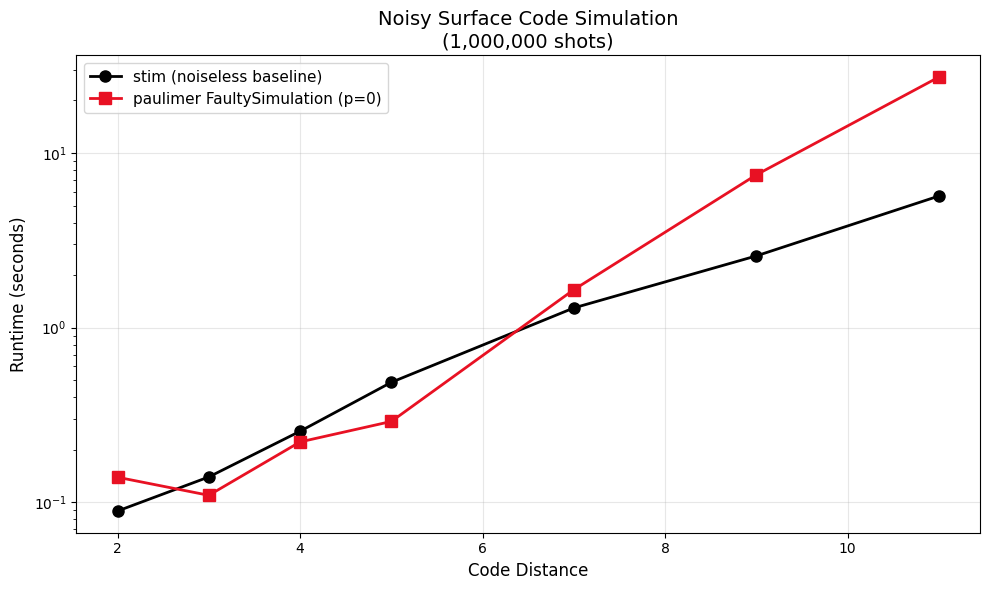


Summary: stim vs paulimer FaultySimulation
  Distance     stim (s)   paulimer (s)      ratio
--------------------------------------------------
         2       0.0891         0.1392      1.56x
         3       0.1397         0.1097      0.79x
         4       0.2552         0.2217      0.87x
         5       0.4865         0.2904      0.60x
         7       1.2974         1.6510      1.27x
         9       2.5768         7.5067      2.91x
        11       5.6753        27.2393      4.80x


In [20]:
# Comparison plot
fig, ax = plt.subplots(figsize=(10, 6))

# Extract data
distances = [r['distance'] for r in stim_results]
stim_times = [r['time_seconds'] for r in stim_results]
paulimer_times = [r['time_seconds'] for r in paulimer_results]

ax.plot(distances, stim_times, 'o-', linewidth=2, markersize=8, 
        label='stim (noiseless baseline)', color='#000000')
ax.plot(distances, paulimer_times, 's-', linewidth=2, markersize=8, 
        label=f'paulimer FaultySimulation (p={P_NOISE})', color='#E81123')

ax.set_xlabel('Code Distance', fontsize=12)
ax.set_ylabel('Runtime (seconds)', fontsize=12)
ax.set_title(f'Noisy Surface Code Simulation\n({NUM_SHOTS:,} shots)', fontsize=14)
ax.set_yscale('log')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=11)

plt.tight_layout()
plt.savefig('paulimer_noisy_benchmark.png', dpi=150)
plt.show()

# Print comparison summary
print("\n" + "="*70)
print("Summary: stim vs paulimer FaultySimulation")
print("="*70)
print(f"{'Distance':>10} {'stim (s)':>12} {'paulimer (s)':>14} {'ratio':>10}")
print("-" * 50)
for i, d in enumerate(distances):
    stim_t = stim_times[i]
    paul_t = paulimer_times[i]
    ratio = paul_t / stim_t
    print(f"{d:>10} {stim_t:>12.4f} {paul_t:>14.4f} {ratio:>9.2f}x")